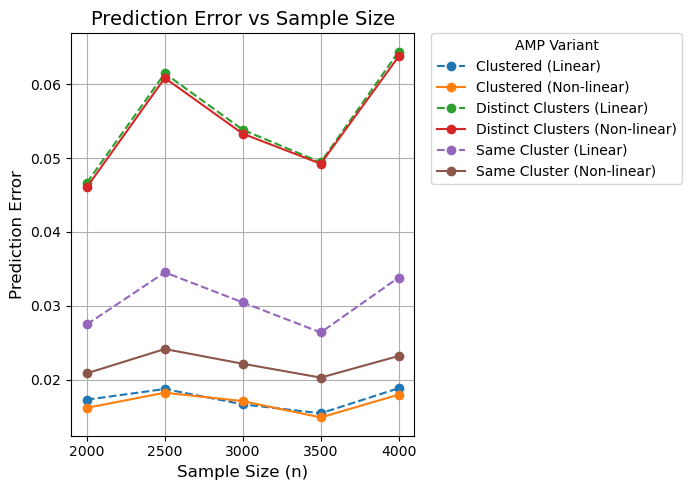

In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import os
import glob
import re

# === Setup paths ===
results_dir = "/home/sagnik/Research/Hierarchical_AMP/Results/pred_nl_comp_lin"
plot_dir = "/home/sagnik/Research/Hierarchical_AMP/Plots/pred_nl_comp_lin"
os.makedirs(plot_dir, exist_ok=True)

# === Load and reshape CSV files ===
csv_files = sorted(glob.glob(os.path.join(results_dir, "predict_result_*.csv")))
records = []

for file in csv_files:
    match = re.search(r"predict_result_(\d+)\.csv", os.path.basename(file))
    if match:
        n_val = int(match.group(1))
        df = pd.read_csv(file)
        df["n"] = n_val
        for method in ["clustered", "same_cluster", "distinct_clusters"]:
            # Non-linear entry
            records.append({
                "n": n_val,
                "Method": method.replace("_", " ").title(),
                "Relation": "Non-linear",
                "PredictionError": df[f"pred_{method}"].values[0]
            })
            # Linear entry
            lin_key = f"pred_{method}_linear"
            if lin_key in df.columns:
                records.append({
                    "n": n_val,
                    "Method": method.replace("_", " ").title(),
                    "Relation": "Linear",
                    "PredictionError": df[lin_key].values[0]
                })

# === Create tidy DataFrame ===
long_df = pd.DataFrame(records)
long_df = long_df.sort_values(["n", "Method", "Relation"])

# === Save tidy data ===
tidy_csv_path = os.path.join(results_dir, "tidy_prediction_results.csv")
long_df.to_csv(tidy_csv_path, index=False)

# === Plotting ===
plt.figure(figsize=(9, 5))
for method in long_df["Method"].unique():
    for relation in ["Linear", "Non-linear"]:
        subset = long_df[(long_df["Method"] == method) & (long_df["Relation"] == relation)]
        linestyle = "--" if relation == "Linear" else "-"
        plt.plot(subset["n"], subset["PredictionError"], marker='o',
                 label=f"{method} ({relation})", linestyle=linestyle)

plt.title("Prediction Error vs Sample Size", fontsize=14)
plt.xlabel("Sample Size (n)", fontsize=12)
plt.ylabel("Prediction Error", fontsize=12)
plt.grid(True)

# Move legend outside the plot
plt.legend(
    title="AMP Variant",
    fontsize=10,
    bbox_to_anchor=(1.05, 1),
    loc='upper left',
    borderaxespad=0.
)

plt.tight_layout(rect=[0, 0, 0.8, 1])  # Leave space on the right for the legend

# Save the plot
plot_path = os.path.join(plot_dir, "prediction_error_vs_n_tidy.png")
plt.savefig(plot_path, dpi=150, bbox_inches='tight')  # bbox_inches ensures space for legend
plt.show()